In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import HTML, display
import ipywidgets as widgets
from ipywidgets import interact

In [4]:
data=pd.read_csv('weight-height.csv')

In [5]:
display(data.info())
display(data.describe())
display(data.shape)
display(data.size)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  10000 non-null  object 
 1   Height  10000 non-null  float64
 2   Weight  10000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 234.5+ KB


None

,Height,Weight
count,10000.000000,10000.000000
mean,66.367560,161.440357
std,3.847528,32.108439
min,54.263133,64.700127
25%,63.505620,135.818051
50%,66.318070,161.212928
75%,69.174262,187.169525
max,78.998742,269.989699


(10000, 3)

30000

In [6]:
display(data.isnull().sum(),
        data.isna().sum(),
        data.duplicated().sum())

Gender    0
Height    0
Weight    0
dtype: int64

Gender    0
Height    0
Weight    0
dtype: int64

np.int64(0)

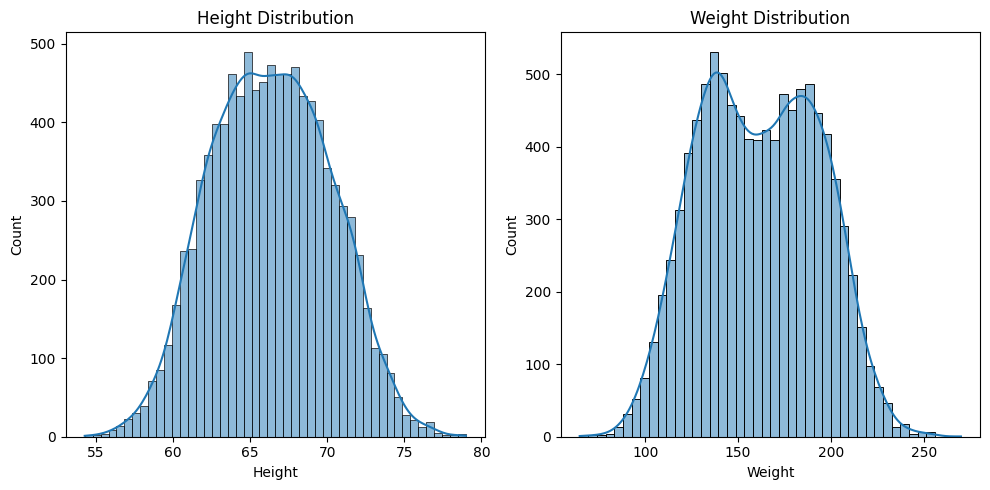

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(data['Height'], kde=True)
plt.title('Height Distribution')
plt.tight_layout()
plt.subplot(1,2,2)
sns.histplot(data['Weight'], kde=True)
plt.title('Weight Distribution')
plt.tight_layout()

Visualisation and outliar counting function

In [8]:
def visualisation(data,mask,method):
    # Visualization - Fixed indexing
    plt.figure(figsize=(10, 6))
    # Plot normal points
    plt.scatter(data.loc[~mask, 'Height'], data.loc[~mask, 'Weight'], 
               label='Normal Points')
    # Plot outliers
    plt.scatter(data.loc[mask, 'Height'], data.loc[mask, 'Weight'], 
               color='red', label='Outliers')
    
    plt.title(method)
    plt.xlabel('Height')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()
    
    outlier_percentage = ((len(data)-len(data[~mask]))/ len(data)) * 100
    display(f"Percentage of outliers: {outlier_percentage:.2f}%")

Z-score 
- measues how many S.D. a data point is from mean 
- value with z score greater than threshold (usually 3) is considered outliar

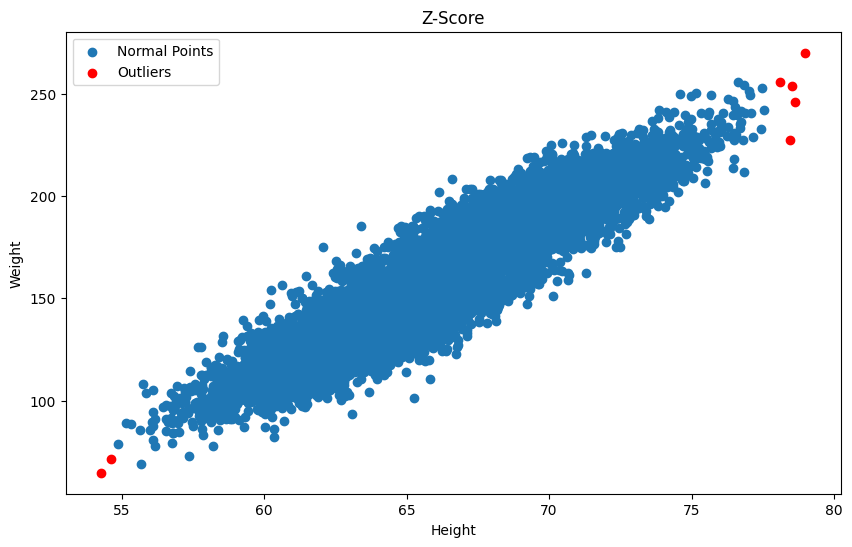

'Percentage of outliers: 0.07%'

In [9]:
def z_score_outliers(data, threshold=3):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    return z_scores > threshold

mask_height = z_score_outliers(data['Height'])
mask_weight = z_score_outliers(data['Weight'])

mask=mask_height|mask_weight 
visualisation(data,mask,"Z-Score")

IQR Method
- it finds out outliers based on quantiles
- q1= 25% of data
- q3= 75% of data
- Iqr=q3-q1= median 50% of data
- using factor mutiplication to find lower and upper bound

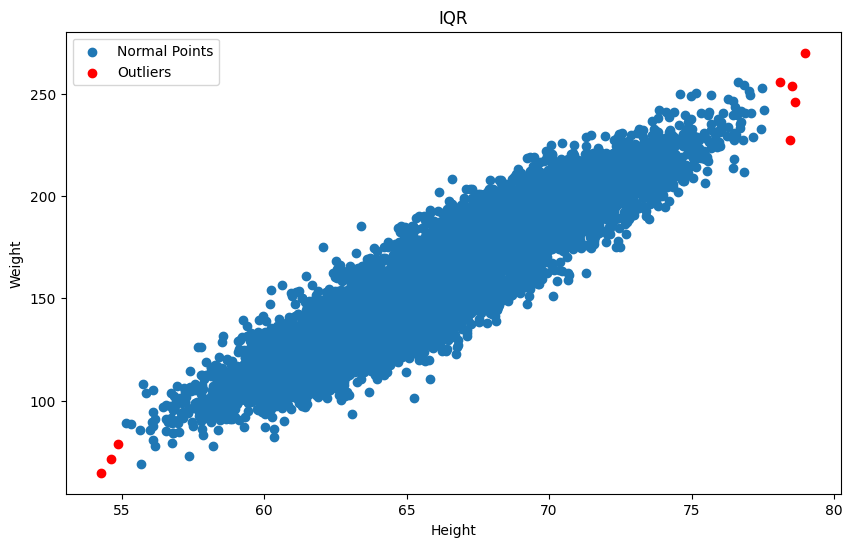

'Percentage of outliers: 0.08%'

In [10]:
def iqr_outliers(data, factor=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
     
    return (data < lower_bound) | (data > upper_bound)

mask_height = iqr_outliers(data['Height'])
mask_weight = iqr_outliers(data['Weight'])

mask= mask_height | mask_weight 
visualisation(data,mask,"IQR")

Isolation Forest
- random selection of data and cutting it to see may lines it need to cut through
- get a value of those data (-ve = outlier)
- https://www.youtube.com/watch?v=Y1x51i1936M

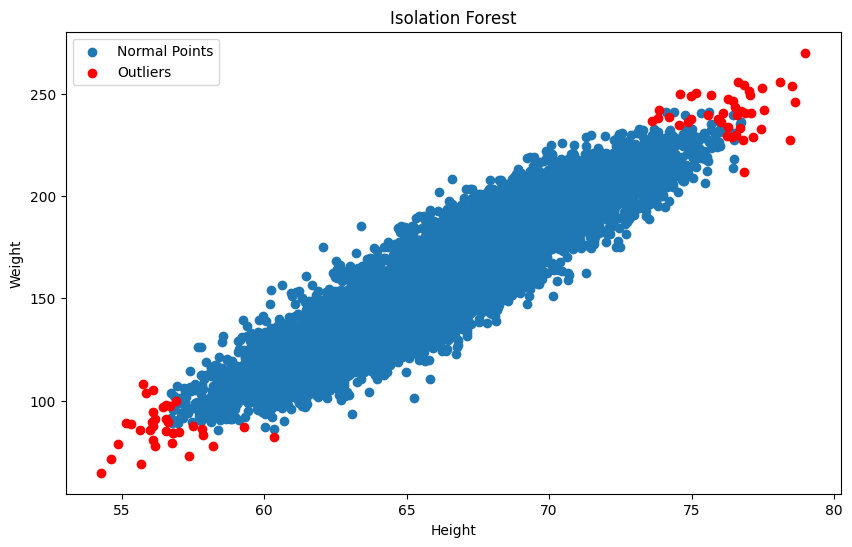

'Percentage of outliers: 0.77%'

In [16]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

def isolation_forest_outliers(data,):
    # Reshape data if it's 1D
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    
    clf = IsolationForest(n_estimators=200,
                          max_samples=0.7,
                          contamination=0.005,
                          random_state=1)
    
    preds = clf.fit_predict(data)
    
    # Convert predictions to boolean mask (1: inliers, -1: outliers)
    return preds == -1

# Apply isolation forest to individual columns
mask_height = isolation_forest_outliers(data['Height'].values)
mask_weight = isolation_forest_outliers(data['Weight'].values)

# Combine masks using OR operation
mask = mask_height | mask_weight
visualisation(data,mask,"Isolation Forest")

Local Outlier Factor
- calculates the local density of a point with the local density of its neighbors
- points with lower local density is considered outliers
- n_estimator= sqrt of data

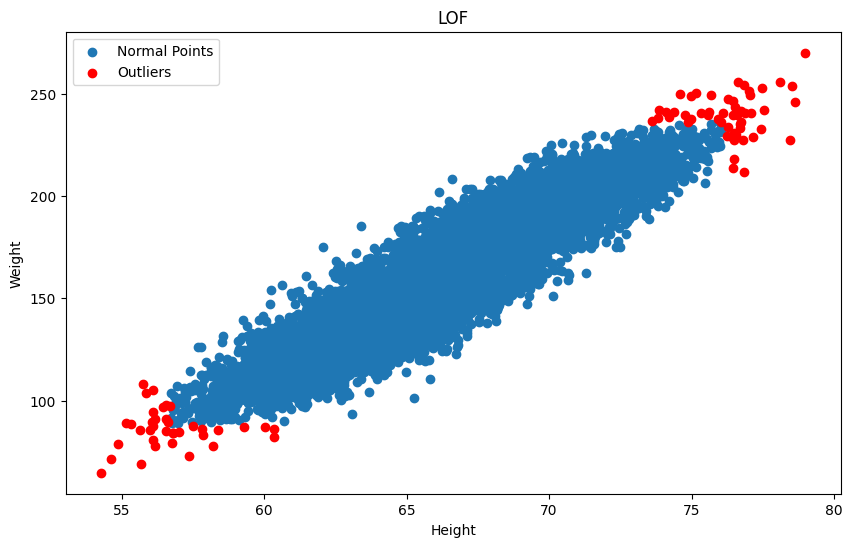

'Percentage of outliers: 0.90%'

In [12]:
from sklearn.neighbors import LocalOutlierFactor
def lof_outliers(data, n_neighbors=100):

    # Reshape data if it's 1D
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    
    clf = LocalOutlierFactor(n_neighbors=n_neighbors)
    preds = clf.fit_predict(data)
    
    # Convert predictions to boolean mask (1: inliers, -1: outliers)
    return preds == -1


# Apply isolation forest to individual columns
mask_height = lof_outliers(data['Height'].values)
mask_weight = lof_outliers(data['Weight'].values)

# Combine masks using OR operation
mask = mask_height | mask_weight

visualisation(data,mask,"LOF")

DBSCAN
Density-Based Spatial Clustering of Applications with Noise
- groups together points that are close to each other (density-connected)
- marks points in low-density regions as outliers
- Points that don't belong to any cluster are considered outliers.

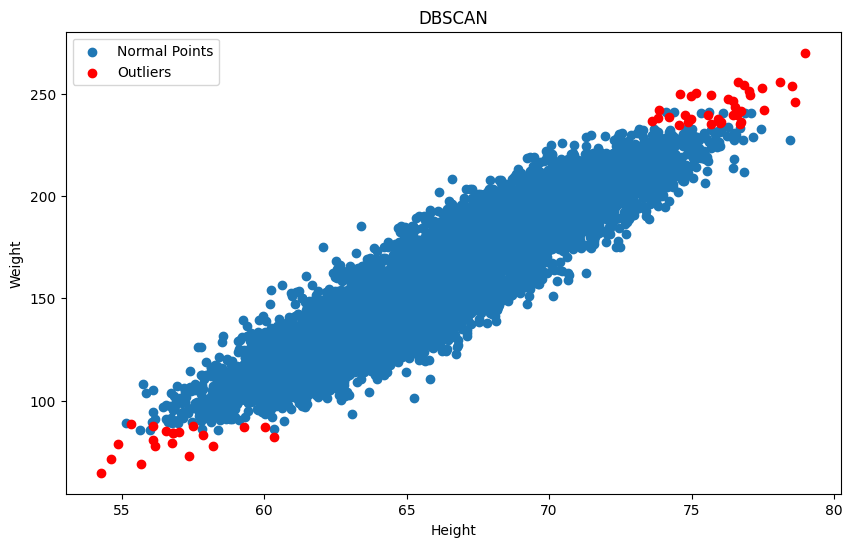

'Percentage of outliers: 0.55%'

In [13]:
from sklearn.cluster import DBSCAN
def dbscan_outliers(data, eps=0.5, min_samples=5):

    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    

    return labels == -1

mask_height = dbscan_outliers(data['Height'].values)
mask_weight = dbscan_outliers(data['Weight'].values)


mask = mask_height | mask_weight

visualisation(data,mask,"DBSCAN")